# Prophet on Total Sales (Units Sold) with Explanatory Variables

In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import logging
import itertools
%matplotlib inline

In [2]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [3]:
def calculate_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    
    smape = 100 * np.mean(numerator / (denominator + 1e-10 ))
    return smape

In [4]:
df = pd.read_csv('../dataset/clustered_data.csv')

In [5]:
total_df = df.groupby('Date')[['UnitsSold', 'AveragePricePerUnitPounds']].sum().reset_index()

In [6]:
total_df['lag_1'] = total_df['UnitsSold'].shift(1)
total_df['lag_7'] = total_df['UnitsSold'].shift(7)
total_df['lag_14'] = total_df['UnitsSold'].shift(14)

total_df['Rolling_Mean_7'] = total_df['UnitsSold'].rolling(window=7).mean()
total_df['Rolling_Std_7'] = total_df['UnitsSold'].rolling(window=7).std()

In [7]:
total_df['lag_1'] = total_df['lag_1'].ffill()
total_df['lag_7'] = total_df['lag_7'].ffill()
total_df['lag_14'] = total_df['lag_14'].ffill()

total_df['Rolling_Mean_7'] = total_df['Rolling_Mean_7'].fillna(total_df['UnitsSold'].expanding().mean())

total_df['Rolling_Std_7'] = total_df['Rolling_Std_7'].fillna(total_df['UnitsSold'].expanding().std().fillna(0))


In [8]:
total_df = total_df.rename(columns={'Date': 'date', 'UnitsSold': "y"})

In [9]:
explanatory_df = pd.read_csv('../explanatory_variables/combined_explanatory_variables.csv')

In [10]:
total_df = total_df.merge(explanatory_df, on='date', how='left')

In [11]:
total_df = total_df.rename(columns={'date': 'ds'})
total_df['ds'] = pd.to_datetime(total_df['ds'])

In [16]:
regressors = ['AveragePricePerUnitPounds', 'gift_ideas',
       'chained-volume-percentage-change-3-months-on-same-period-a-year-earlier',
       'chained-volume-percentage-change-on-previous-month',
       'chained-volume-percentage-change-on-same-month-a-year-earlier',
       'current-prices-percentage-change-on-previous-month',
       'current-prices-percentage-change-on-same-month-a-year-earlier',
       'is_black_friday', 'is_cyber_monday', 'cpi', 'cci', 'interest_rate',
       'unemployment_rate', 'is_holiday', 'is_Friday', 'is_Monday',
       'is_Saturday', 'is_Sunday', 'is_Thursday', 'is_Tuesday',
       'is_Wednesday', 'lag_1',
       'lag_7',
       'lag_14',
       'Rolling_Mean_7',
       'Rolling_Std_7']

total_df[regressors] = total_df[regressors].ffill().bfill()

In [17]:
n = len(total_df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_data = total_df.iloc[:train_end]
validation_data = total_df.iloc[train_end:val_end]
test_data = total_df.iloc[val_end:]

In [18]:
clip_threshold = np.percentile(total_df['y'], 99)

In [19]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

for reg in regressors:
    model.add_regressor(reg)
    
model.fit(train_data)

21:01:45 - cmdstanpy - INFO - Chain [1] start processing
21:01:45 - cmdstanpy - INFO - Chain [1] done processing


## Validation

In [20]:
validation_forecast = model.predict(validation_data)

In [21]:
actual_values = np.array(validation_data['y'])
predicted_values = np.array(validation_forecast['yhat'])

In [22]:
validation_smape = calculate_smape(actual_values, predicted_values)
validation_smape

38.11723684944208

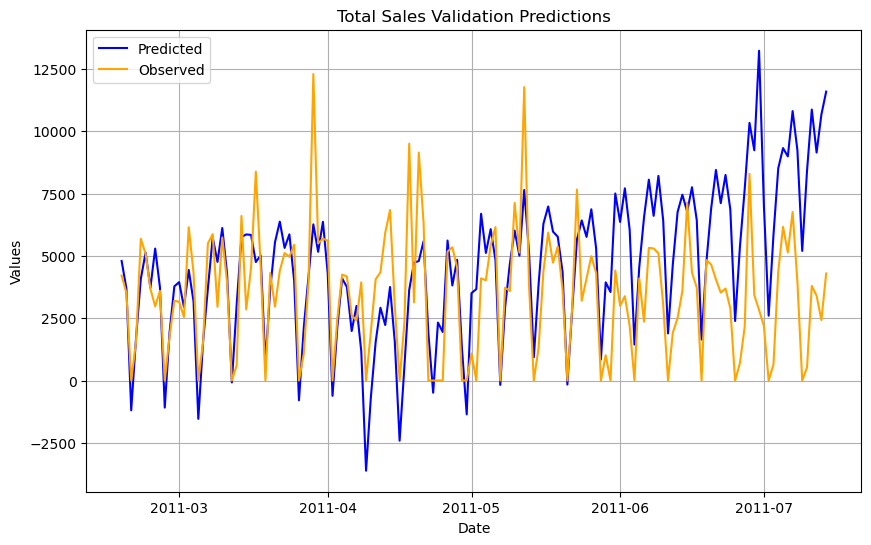

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(validation_data['ds']), validation_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(validation_data['ds']), validation_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Validation Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Test

In [24]:
test_forecast = model.predict(test_data)

In [25]:
actual_values = np.array(test_data['y'])
predicted_values = np.array(test_forecast['yhat'])

In [26]:
test_smape = calculate_smape(actual_values, predicted_values)
test_smape

41.45707333855119

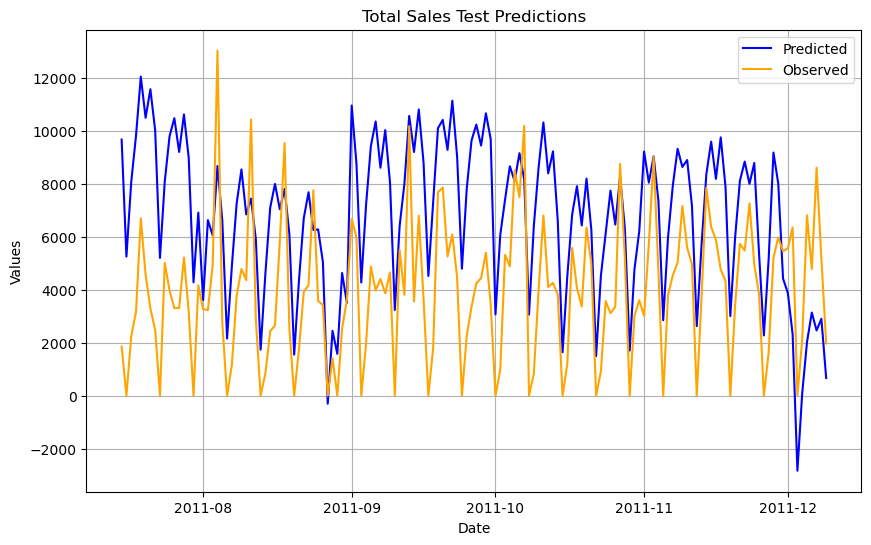

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(test_data['ds']), test_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(test_data['ds']), test_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Overall

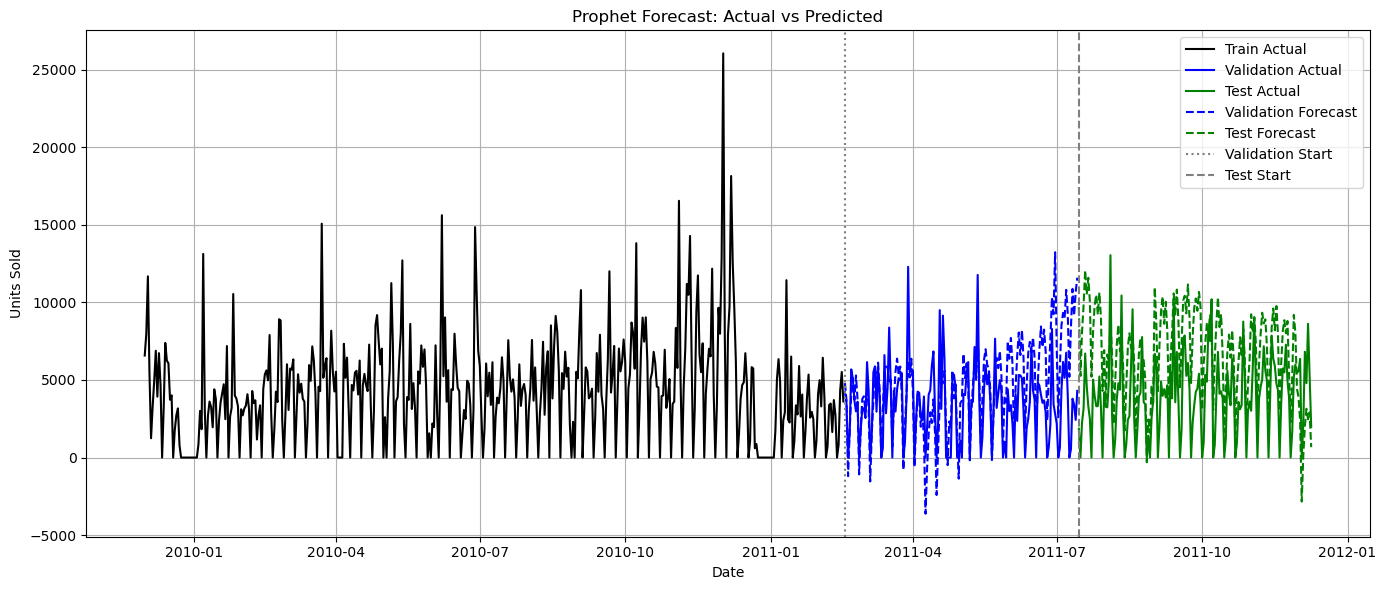

In [28]:
plt.figure(figsize=(14, 6))

plt.plot(train_data['ds'], train_data['y'], label='Train Actual', color='black')
plt.plot(validation_data['ds'], validation_data['y'], label='Validation Actual', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Actual', color='green')

plt.plot(validation_forecast['ds'], validation_forecast['yhat'], label='Validation Forecast', color='blue', linestyle='--')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Test Forecast', color='green', linestyle='--')

plt.axvline(x=validation_data['ds'].min(), color='gray', linestyle=':', label='Validation Start')
plt.axvline(x=test_data['ds'].min(), color='gray', linestyle='--', label='Test Start')

plt.title('Prophet Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Tuning

In [29]:
param_grid = {
    "changepoint_prior_scale": [0.01, 0.05, 0.1, 0.2, 0.5],
    "seasonality_prior_scale": [0.05, 0.1, 0.5, 1, 5],
    "fourier_order": [3, 5, 10]
}

best_smape = float("inf")
best_params = None
best_model = None

In [30]:
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
validation_data = validation_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

In [31]:
# Grid search loop
for cps, sps, fo in itertools.product(
    param_grid["changepoint_prior_scale"],
    param_grid["seasonality_prior_scale"],
    param_grid["fourier_order"]
):
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps
    )

    # Add custom monthly seasonality
    model.add_seasonality(name="monthly", period=30.5, fourier_order=fo)

    for reg in regressors:
        model.add_regressor(reg)

    try:
        # Fit model
        model.fit(train_data)

        # Predict on test
        future = validation_data[['ds'] + regressors]
        forecast = model.predict(future)

        # Evaluate
        y_true = validation_data["y"]
        y_pred = np.clip(forecast["yhat"], 0, clip_threshold)

        smape = calculate_smape(y_true, y_pred)

        print(f"cps={cps}, sps={sps}, fo={fo}: SMAPE={smape:.2f}%")

        if smape < best_smape:
            best_smape = smape
            best_params = (cps, sps, fo)
            best_model = model

    except Exception as e:
        print(f"⚠️ Skipping params (cps={cps}, sps={sps}, fo={fo}) due to error: {e}")

21:01:46 - cmdstanpy - INFO - Chain [1] start processing
21:01:46 - cmdstanpy - INFO - Chain [1] done processing
21:01:46 - cmdstanpy - INFO - Chain [1] start processing
21:01:46 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.05, fo=3: SMAPE=29.19%


21:01:46 - cmdstanpy - INFO - Chain [1] start processing
21:01:46 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.05, fo=5: SMAPE=29.46%


21:01:47 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.05, fo=10: SMAPE=31.01%


21:01:47 - cmdstanpy - INFO - Chain [1] start processing


cps=0.01, sps=0.1, fo=3: SMAPE=30.33%


21:01:47 - cmdstanpy - INFO - Chain [1] done processing
21:01:47 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.1, fo=5: SMAPE=32.64%


21:01:47 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.1, fo=10: SMAPE=32.77%


21:01:48 - cmdstanpy - INFO - Chain [1] start processing
21:01:48 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.5, fo=3: SMAPE=32.42%


21:01:48 - cmdstanpy - INFO - Chain [1] start processing
21:01:48 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.5, fo=5: SMAPE=31.90%


21:01:48 - cmdstanpy - INFO - Chain [1] start processing
21:01:48 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.5, fo=10: SMAPE=34.11%


21:01:49 - cmdstanpy - INFO - Chain [1] start processing
21:01:49 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=1, fo=3: SMAPE=33.84%


21:01:49 - cmdstanpy - INFO - Chain [1] start processing
21:01:49 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=1, fo=5: SMAPE=32.20%


21:01:49 - cmdstanpy - INFO - Chain [1] start processing
21:01:49 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=1, fo=10: SMAPE=34.58%


21:01:49 - cmdstanpy - INFO - Chain [1] start processing


cps=0.01, sps=5, fo=3: SMAPE=33.31%


21:01:49 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=5, fo=5: SMAPE=31.02%


21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=5, fo=10: SMAPE=33.79%


21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.05, fo=3: SMAPE=26.99%


21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.05, fo=5: SMAPE=21.04%


21:01:51 - cmdstanpy - INFO - Chain [1] start processing
21:01:51 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.05, fo=10: SMAPE=27.80%


21:01:51 - cmdstanpy - INFO - Chain [1] start processing
21:01:51 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.1, fo=3: SMAPE=27.68%


21:01:51 - cmdstanpy - INFO - Chain [1] start processing
21:01:51 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.1, fo=5: SMAPE=25.02%


21:01:51 - cmdstanpy - INFO - Chain [1] start processing
21:01:51 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.1, fo=10: SMAPE=27.66%


21:01:52 - cmdstanpy - INFO - Chain [1] start processing


cps=0.05, sps=0.5, fo=3: SMAPE=28.00%


21:01:52 - cmdstanpy - INFO - Chain [1] done processing
21:01:52 - cmdstanpy - INFO - Chain [1] start processing
21:01:52 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.5, fo=5: SMAPE=26.85%


21:01:52 - cmdstanpy - INFO - Chain [1] start processing
21:01:52 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.5, fo=10: SMAPE=27.74%


21:01:53 - cmdstanpy - INFO - Chain [1] start processing
21:01:53 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=1, fo=3: SMAPE=25.24%


21:01:53 - cmdstanpy - INFO - Chain [1] start processing
21:01:53 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=1, fo=5: SMAPE=24.43%


21:01:53 - cmdstanpy - INFO - Chain [1] start processing
21:01:53 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=1, fo=10: SMAPE=27.93%


21:01:53 - cmdstanpy - INFO - Chain [1] start processing


cps=0.05, sps=5, fo=3: SMAPE=25.41%


21:01:54 - cmdstanpy - INFO - Chain [1] done processing
21:01:54 - cmdstanpy - INFO - Chain [1] start processing


cps=0.05, sps=5, fo=5: SMAPE=27.47%


21:01:54 - cmdstanpy - INFO - Chain [1] done processing
21:01:54 - cmdstanpy - INFO - Chain [1] start processing


cps=0.05, sps=5, fo=10: SMAPE=27.67%


21:01:54 - cmdstanpy - INFO - Chain [1] done processing
21:01:55 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=0.05, fo=3: SMAPE=25.45%


21:01:55 - cmdstanpy - INFO - Chain [1] done processing
21:01:55 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=0.05, fo=5: SMAPE=24.31%


21:01:55 - cmdstanpy - INFO - Chain [1] done processing
21:01:55 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=0.05, fo=10: SMAPE=26.31%


21:01:55 - cmdstanpy - INFO - Chain [1] done processing
21:01:56 - cmdstanpy - INFO - Chain [1] start processing
21:01:56 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.1, fo=3: SMAPE=27.73%


21:01:56 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=0.1, fo=5: SMAPE=23.78%


21:01:56 - cmdstanpy - INFO - Chain [1] done processing
21:01:56 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=0.1, fo=10: SMAPE=27.39%


21:01:56 - cmdstanpy - INFO - Chain [1] done processing
21:01:57 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=0.5, fo=3: SMAPE=28.21%


21:01:57 - cmdstanpy - INFO - Chain [1] done processing
21:01:57 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=0.5, fo=5: SMAPE=25.93%


21:01:57 - cmdstanpy - INFO - Chain [1] done processing
21:01:58 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=0.5, fo=10: SMAPE=24.70%


21:01:58 - cmdstanpy - INFO - Chain [1] done processing
21:01:58 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=1, fo=3: SMAPE=28.39%


21:01:58 - cmdstanpy - INFO - Chain [1] done processing
21:01:59 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=1, fo=5: SMAPE=27.07%


21:01:59 - cmdstanpy - INFO - Chain [1] done processing
21:01:59 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=1, fo=10: SMAPE=27.62%


21:01:59 - cmdstanpy - INFO - Chain [1] done processing
21:01:59 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=5, fo=3: SMAPE=25.55%


21:01:59 - cmdstanpy - INFO - Chain [1] done processing
21:02:00 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=5, fo=5: SMAPE=27.27%


21:02:00 - cmdstanpy - INFO - Chain [1] done processing
21:02:00 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=5, fo=10: SMAPE=28.81%


21:02:00 - cmdstanpy - INFO - Chain [1] done processing
21:02:01 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=0.05, fo=3: SMAPE=23.02%


21:02:01 - cmdstanpy - INFO - Chain [1] done processing
21:02:01 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=0.05, fo=5: SMAPE=20.77%


21:02:01 - cmdstanpy - INFO - Chain [1] done processing
21:02:01 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=0.05, fo=10: SMAPE=23.69%


21:02:02 - cmdstanpy - INFO - Chain [1] done processing
21:02:02 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=0.1, fo=3: SMAPE=22.47%


21:02:02 - cmdstanpy - INFO - Chain [1] done processing
21:02:02 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=0.1, fo=5: SMAPE=21.02%


21:02:02 - cmdstanpy - INFO - Chain [1] done processing
21:02:03 - cmdstanpy - INFO - Chain [1] start processing
21:02:03 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.1, fo=10: SMAPE=21.66%


21:02:03 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=0.5, fo=3: SMAPE=28.52%


21:02:03 - cmdstanpy - INFO - Chain [1] done processing
21:02:03 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=0.5, fo=5: SMAPE=22.95%


21:02:03 - cmdstanpy - INFO - Chain [1] done processing
21:02:04 - cmdstanpy - INFO - Chain [1] start processing
21:02:04 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.5, fo=10: SMAPE=23.38%


21:02:04 - cmdstanpy - INFO - Chain [1] start processing
21:02:04 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=1, fo=3: SMAPE=26.24%


21:02:04 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=1, fo=5: SMAPE=27.51%


21:02:04 - cmdstanpy - INFO - Chain [1] done processing
21:02:05 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=1, fo=10: SMAPE=21.27%


21:02:05 - cmdstanpy - INFO - Chain [1] done processing
21:02:05 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=5, fo=3: SMAPE=21.74%


21:02:05 - cmdstanpy - INFO - Chain [1] done processing
21:02:05 - cmdstanpy - INFO - Chain [1] start processing
21:02:05 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=5, fo=5: SMAPE=21.82%


21:02:06 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=5, fo=10: SMAPE=23.83%


21:02:06 - cmdstanpy - INFO - Chain [1] done processing
21:02:06 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.05, fo=3: SMAPE=25.84%


21:02:06 - cmdstanpy - INFO - Chain [1] done processing
21:02:06 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.05, fo=5: SMAPE=26.80%


21:02:06 - cmdstanpy - INFO - Chain [1] done processing
21:02:07 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.05, fo=10: SMAPE=34.99%


21:02:07 - cmdstanpy - INFO - Chain [1] done processing
21:02:07 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.1, fo=3: SMAPE=22.49%


21:02:07 - cmdstanpy - INFO - Chain [1] done processing
21:02:07 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.1, fo=5: SMAPE=21.76%


21:02:08 - cmdstanpy - INFO - Chain [1] done processing
21:02:08 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.1, fo=10: SMAPE=21.49%


21:02:08 - cmdstanpy - INFO - Chain [1] done processing
21:02:08 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.5, fo=3: SMAPE=20.29%


21:02:08 - cmdstanpy - INFO - Chain [1] done processing
21:02:09 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.5, fo=5: SMAPE=21.85%


21:02:09 - cmdstanpy - INFO - Chain [1] done processing
21:02:09 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.5, fo=10: SMAPE=21.64%


21:02:09 - cmdstanpy - INFO - Chain [1] done processing
21:02:09 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=1, fo=3: SMAPE=20.44%


21:02:09 - cmdstanpy - INFO - Chain [1] done processing
21:02:10 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=1, fo=5: SMAPE=22.79%


21:02:10 - cmdstanpy - INFO - Chain [1] done processing
21:02:10 - cmdstanpy - INFO - Chain [1] start processing
21:02:10 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=1, fo=10: SMAPE=23.96%


21:02:10 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=5, fo=3: SMAPE=20.37%


21:02:10 - cmdstanpy - INFO - Chain [1] done processing
21:02:11 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=5, fo=5: SMAPE=21.33%


21:02:11 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=5, fo=10: SMAPE=21.24%


In [32]:
print(f"\n✅ Best Parameters: changepoint_prior_scale={best_params[0]}, "
      f"seasonality_prior_scale={best_params[1]}, fourier_order={best_params[2]}")
print(f"📉 Best SMAPE on Validation Set: {best_smape:.2f}%")

best_test_forecast = best_model.predict(test_data[["ds"]+regressors])
best_test_forecast['yhat'] = np.clip(best_test_forecast['yhat'], 0, clip_threshold)
best_validation_forecast = best_model.predict(validation_data[["ds"] + regressors])
best_validation_forecast['yhat'] = np.clip(best_validation_forecast['yhat'], 0, clip_threshold)


✅ Best Parameters: changepoint_prior_scale=0.5, seasonality_prior_scale=0.5, fourier_order=3
📉 Best SMAPE on Validation Set: 20.29%


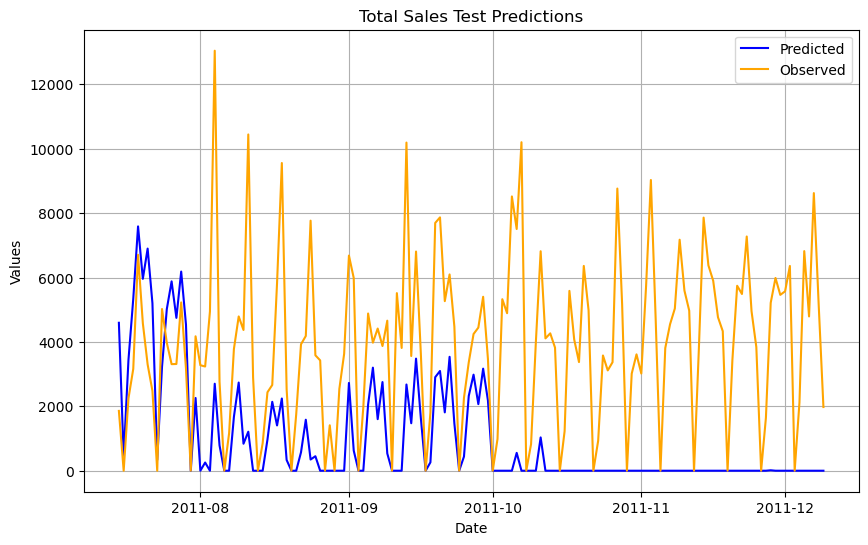

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(test_data['ds']), best_test_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(test_data['ds']), test_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

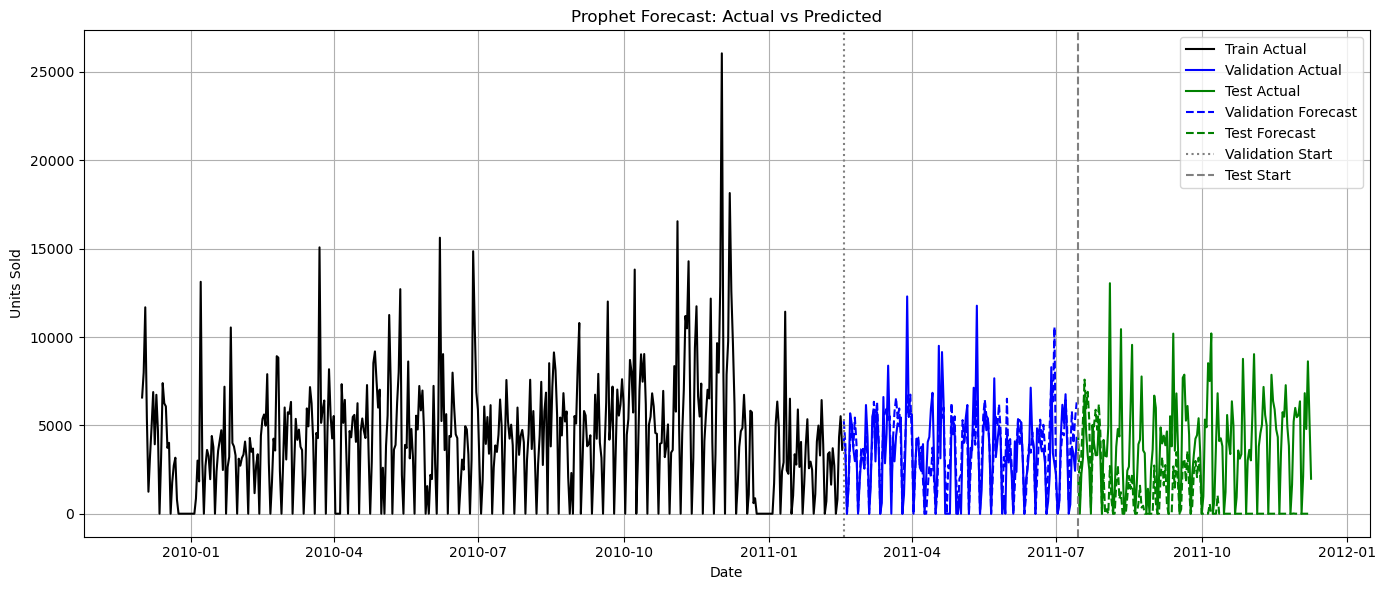

In [34]:
plt.figure(figsize=(14, 6))

plt.plot(train_data['ds'], train_data['y'], label='Train Actual', color='black')
plt.plot(validation_data['ds'], validation_data['y'], label='Validation Actual', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Actual', color='green')

plt.plot(best_validation_forecast['ds'], best_validation_forecast['yhat'], label='Validation Forecast', color='blue', linestyle='--')
plt.plot(best_test_forecast['ds'], best_test_forecast['yhat'], label='Test Forecast', color='green', linestyle='--')

plt.axvline(x=validation_data['ds'].min(), color='gray', linestyle=':', label='Validation Start')
plt.axvline(x=test_data['ds'].min(), color='gray', linestyle='--', label='Test Start')

plt.title('Prophet Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
